# 👩🏻‍🔬 Data Poisoning Simulation

In this section, I aim to simulate the impact of data poisoning on an original dataset and then apply mitigation techniques outlined in Section VI-B. However, due to the limited availability of relevant source codes online and the complexity of certain implementations beyond my domain knowledge, I designed the experiment independently.

Using an artificial dataset and machine learning techniques I am familiar with, I developed a customized approach to evaluate and counteract data poisoning.

In [27]:
# Required packages importing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib.colors import ListedColormap

### 1️⃣ Clean Data

In [3]:
# Generate a synthetic dataset (binary classification)
def generate_data(n_samples=500, noise=0.1):
    np.random.seed(42)
    X = np.random.randn(n_samples, 2)  # Two feature columns
    y = (X[:, 0] + X[:, 1] > 0).astype(int)  # Simple decision boundary
    return X, y

# Train and evaluate the model - Random Forest
def train_evaluate(X_train, y_train, X_test, y_test, title="Model Performance"):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{title} (Accuracy: {acc:.2f}')
    plt.show()

    return acc

# Data Distribution Visualization
def plot_data_distribution(X, y, title):
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=['blue', 'red'], alpha=0.6)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.show()

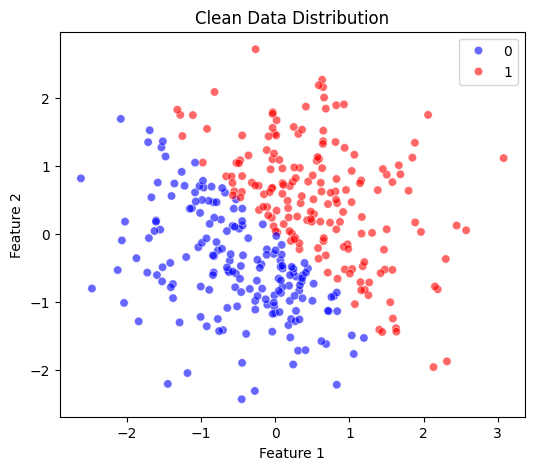

In [4]:
X, y = generate_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
plot_data_distribution(X_train, y_train, "Clean Data Distribution")

Training on clean data:


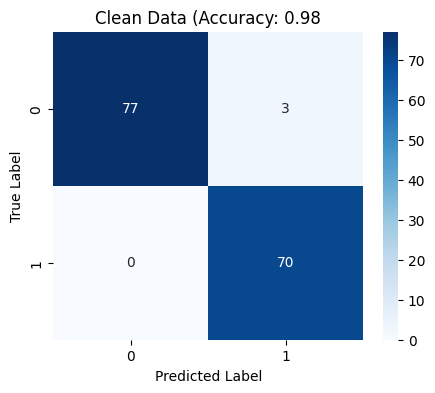

In [5]:
print("Training on clean data:")
acc_clean = train_evaluate(X_train, y_train, X_test, y_test, "Clean Data")

### 2️⃣ Poisoned Data

In [6]:
# Introduce data poisoning
# Method: Flip labels for some percentage of the data and insert misleading samples
def poison_data(X, y, poison_rate=0.3):  # Increased poisoning rate
    np.random.seed(42)
    poisoned_X = X.copy()
    poisoned_y = y.copy()
    n_poison = int(len(y) * poison_rate)
    poison_indices = np.random.choice(len(y), n_poison, replace=False)

    # Flip labels
    poisoned_y[poison_indices] = 1 - poisoned_y[poison_indices]

    # Add stronger random noise to features
    poisoned_X[poison_indices] += np.random.normal(0, 2.0, size=poisoned_X[poison_indices].shape)

    # Insert entirely misleading samples
    fake_X = np.random.uniform(-3, 3, size=(n_poison, 2))
    fake_y = np.random.randint(0, 2, size=n_poison)
    poisoned_X = np.vstack([poisoned_X, fake_X])
    poisoned_y = np.hstack([poisoned_y, fake_y])

    return poisoned_X, poisoned_y

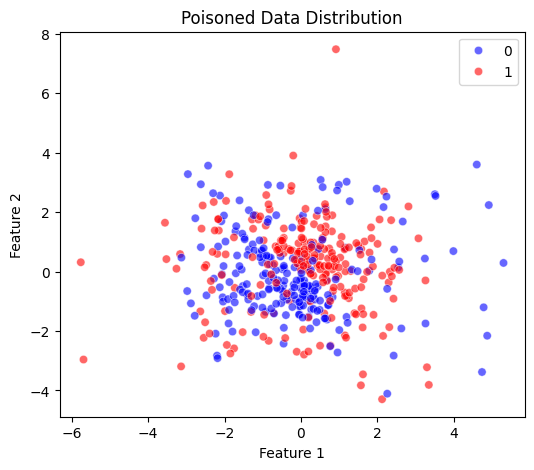

In [7]:
X_poisoned, y_poisoned = poison_data(X_train, y_train)
plot_data_distribution(X_poisoned, y_poisoned, "Poisoned Data Distribution")

Training on poisoned data:


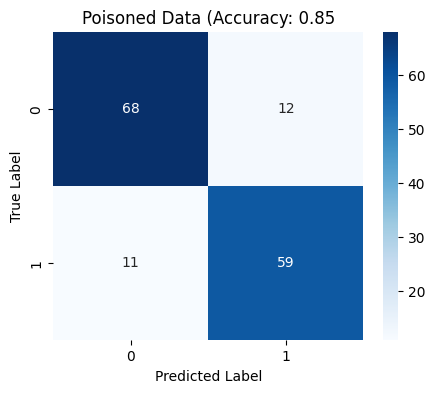

In [8]:
print("Training on poisoned data:")
acc_poisoned = train_evaluate(X_poisoned, y_poisoned, X_test, y_test, "Poisoned Data")

### 3️⃣ Data Cleaning (Removing extreme outliers)

In [9]:
# Mitigation 1 - Data Validation & Cleaning (Removing extreme outliers)
def clean_data(X, y, threshold=2.5):
    z_scores = np.abs((X - X.mean(axis=0)) / X.std(axis=0))
    mask = (z_scores < threshold).all(axis=1)
    return X[mask], y[mask]

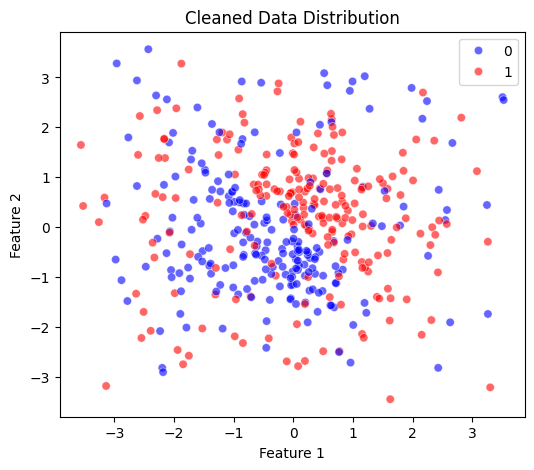

In [10]:
X_cleaned, y_cleaned = clean_data(X_poisoned, y_poisoned)
plot_data_distribution(X_cleaned, y_cleaned, "Cleaned Data Distribution")

Training after data cleaning:


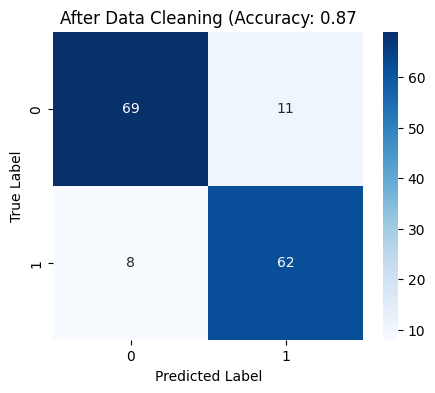

In [11]:
print("Training after data cleaning:")
acc_cleaned = train_evaluate(X_cleaned, y_cleaned, X_test, y_test, "After Data Cleaning")

### 4️⃣ Anomaly Detection (Using Isolation Forest)

In [12]:
# Mitigation 2 - Anomaly Detection (Using Isolation Forest)
def remove_anomalies(X, y):
    clf = IsolationForest(contamination=0.15, random_state=42)
    preds = clf.fit_predict(X)
    mask = preds == 1
    return X[mask], y[mask]

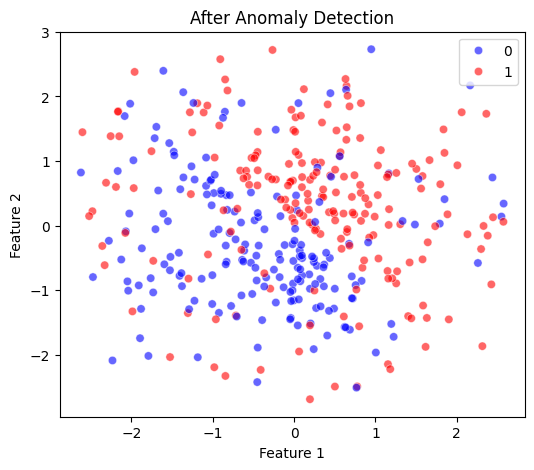

In [13]:
X_filtered, y_filtered = remove_anomalies(X_poisoned, y_poisoned)
plot_data_distribution(X_filtered, y_filtered, "After Anomaly Detection")

Training after anomaly detection:


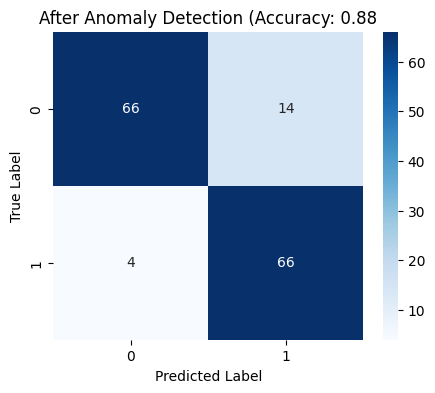

In [14]:
print("Training after anomaly detection:")
acc_filtered = train_evaluate(X_filtered, y_filtered, X_test, y_test, "After Anomaly Detection")

### ✍🏻 Performance Comparison

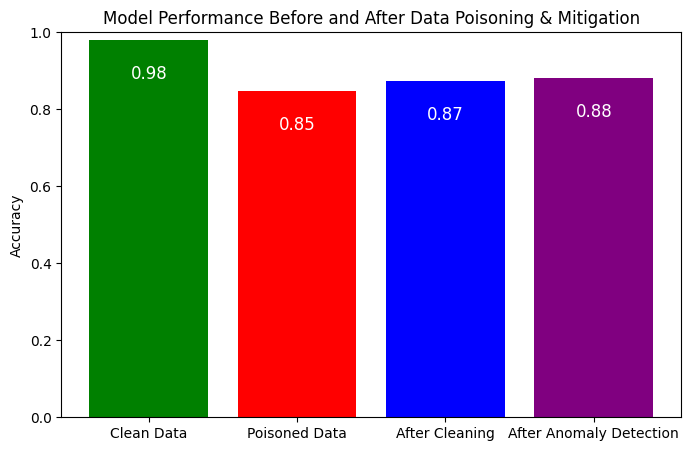

In [26]:
# Compare accuracy results
labels = ["Clean Data", "Poisoned Data", "After Cleaning", "After Anomaly Detection"]
accuracies = [acc_clean, acc_poisoned, acc_cleaned, acc_filtered]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, accuracies, color=['green', 'red', 'blue', 'purple'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval - 0.1, f"{yval:.2f}", ha='center', fontsize=12, color='white')

plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Performance Before and After Data Poisoning & Mitigation")
plt.show()

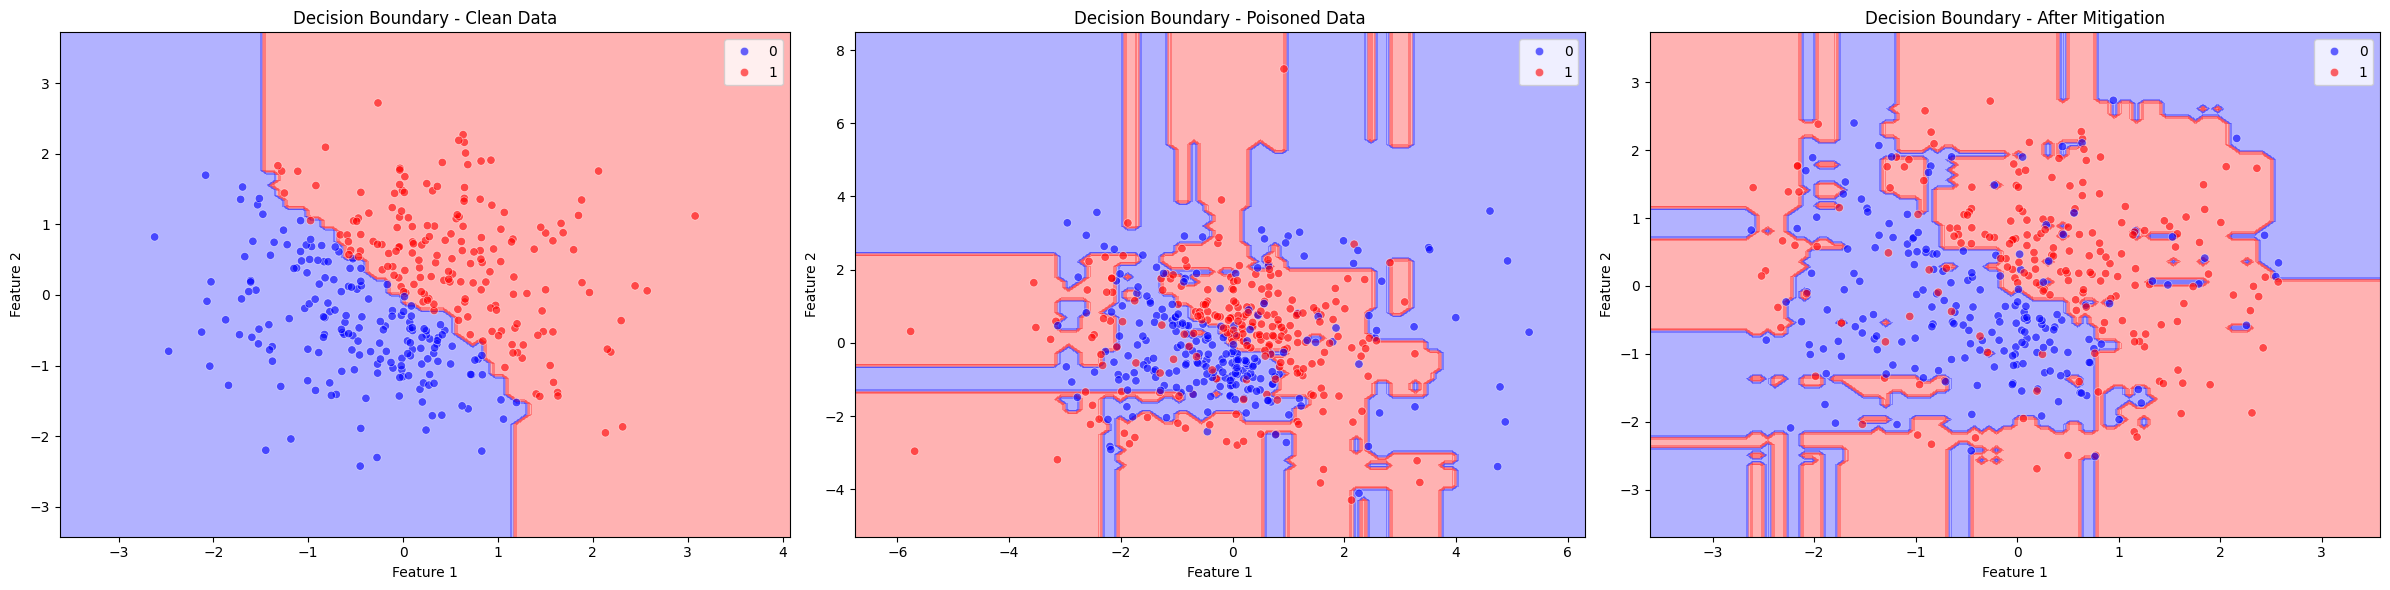

In [29]:
# Decision Boundary Visualization
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

decision_titles = ["Decision Boundary - Clean Data", "Decision Boundary - Poisoned Data", "Decision Boundary - After Mitigation"]
data_models = [(X_train, y_train, RandomForestClassifier(n_estimators=100, random_state=42)),
               (X_poisoned, y_poisoned, RandomForestClassifier(n_estimators=100, random_state=42)),
               (X_filtered, y_filtered, RandomForestClassifier(n_estimators=100, random_state=42))]

for ax, (X, y, model), title in zip(axes, data_models, decision_titles):
    model.fit(X, y)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['blue', 'red']))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=['blue', 'red'], alpha=0.6, ax=ax)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_title(title)

plt.tight_layout()
plt.show()

### If we just introduce small amount of poisoned data and try to recover...🤔

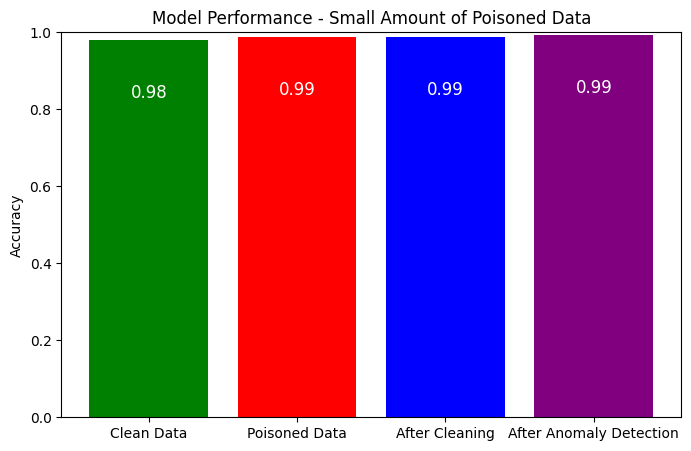

In [35]:
# Introduce small amount of data poisoning
def poison_data(X, y, poison_rate=0.05):  # Small amount of poisoning
    np.random.seed(42)
    poisoned_X = X.copy()
    poisoned_y = y.copy()
    n_poison = int(len(y) * poison_rate)
    poison_indices = np.random.choice(len(y), n_poison, replace=False)

    # Flip labels
    poisoned_y[poison_indices] = 1 - poisoned_y[poison_indices]

    # Add slight noise to features
    poisoned_X[poison_indices] += np.random.normal(0, 0.5, size=poisoned_X[poison_indices].shape)

    return poisoned_X, poisoned_y

# Mitigation 1 - Data Validation & Cleaning (Removing extreme outliers)
def clean_data(X, y, threshold=2.0):  # Adjusted for slight noise
    z_scores = np.abs((X - X.mean(axis=0)) / X.std(axis=0))
    mask = (z_scores < threshold).all(axis=1)
    return X[mask], y[mask]

# Mitigation 2 - Anomaly Detection (Using Isolation Forest)
def remove_anomalies(X, y):
    clf = IsolationForest(contamination=0.02, random_state=42)  # Lower contamination
    preds = clf.fit_predict(X)
    mask = preds == 1
    return X[mask], y[mask]

X, y = generate_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Poison the data with small perturbations
X_poisoned, y_poisoned = poison_data(X_train, y_train)

# Apply data cleaning
X_cleaned, y_cleaned = clean_data(X_poisoned, y_poisoned)

# Apply anomaly detection
X_filtered, y_filtered = remove_anomalies(X_poisoned, y_poisoned)


# Compare accuracy results
labels = ["Clean Data", "Poisoned Data", "After Cleaning", "After Anomaly Detection"]
accuracies = [acc_clean, acc_poisoned, acc_cleaned, acc_filtered]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, accuracies, color=['green', 'red', 'blue', 'purple'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval - 0.15, f"{yval:.2f}", ha='center', fontsize=12, color='white')

plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Performance - Small Amount of Poisoned Data")
plt.show()